## Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sklearn

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path
from IPython.display import Image, display, Video, HTML
from ipywidgets import interact, widgets

from signlens.params import *
from signlens.preprocessing import data, preprocess
from signlens.model import workflow
from signlens.model.model_architecture import initialize_model, compile_model, train_model, evaluate_model
from signlens.model import model_utils

from utils import plot_landmarks

# reload automatically python functions outside notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fetch data

In [14]:
# variables loaded from .env
print(f"DATA_FRAC : {DATA_FRAC}")
print(f"NUM_CLASSES : {NUM_CLASSES}")
print(f"MAX_SEQ_LEN : {MAX_SEQ_LEN}")

n_frames=MAX_SEQ_LEN
n_landmarks=N_LANDMARKS_NO_FACE
num_classes=NUM_CLASSES

DATA_FRAC : 0.1
NUM_CLASSES : 10
MAX_SEQ_LEN : 100


In [7]:
random_state = 42
X_train, X_val, y_train, y_val = workflow.preprocess(random_state=random_state)


⭐️ Use case: preprocess
Loading data subset from train_train.csv
    ℹ️ Random state set for data loading : 42
    ℹ️ Filtered sequences with missing frames. Size reduced from 77228 to 77228 (100.00%)
    ℹ️ Filtered on n_frames = 100. Size reduced from 77228 to 68935 (89.26%)
    ℹ️ Filtered on n_classes = 10. Size reduced from 68935 to 2801 (4.06%)
    ℹ️ Balanced data, with average of 28.0 elements per class. Size reduced from 2801 to 280 (10.00%)
✅ Loaded 280 rows (0.36% of the original 77228 rows) from the dataset.

Preprocessing 224 training files...


/home/bfrisque/.pyenv/versions/3.10.6/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:03<00:00, 61.02it/s]



Preprocessing 56 validation files...


2024-03-26 12:02:06.991760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 12:02:06.992884: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.13it/s]


In [9]:
y_train.sum(axis=0)

array([22., 23., 22., 22., 23., 22., 22., 22., 23., 23.])

In [10]:
y_val.sum(axis=0)

array([6., 5., 6., 6., 5., 6., 6., 6., 5., 5.])

## Model

In [11]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Masking, Flatten, Dropout, SimpleRNN, Reshape, Bidirectional, Input, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, SimpleRNN, LSTM, Dense, Dropout, Masking, BatchNormalization

# Define model
model = Sequential()

# Input layer with masking
model.add(Input(shape=(n_frames, n_landmarks * 3)))
model.add(Masking(mask_value=MASK_VALUE))

model.add(BatchNormalization())

# Recurrent layers
model.add(SimpleRNN(units=128, return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 100, 225)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 225)       │           900 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 128)       │        45,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,286 (1.21 MB)

 Trainable params: 317,836 (1.21 MB)

 Non-trainable params: 450 (1.76 KB)

In [17]:
# Compilation
model = compile_model(model)

# Fitting
paths = model_utils.create_model_folder()
patience = 15
epochs=100
verbose=1
batch_size=32
validation_data=(X_val, y_val)
shuffle=False

model, history = train_model(model, X_train, y_train,
                                 patience=patience,
                                 epochs=epochs,
                                 verbose=verbose,
                                 batch_size=batch_size,
                                 validation_data=validation_data,
                                 shuffle=shuffle,
                                 model_save_epoch_path=paths['iter']
                                 )


Training model...
Epoch 1/100



KeyboardInterrupt



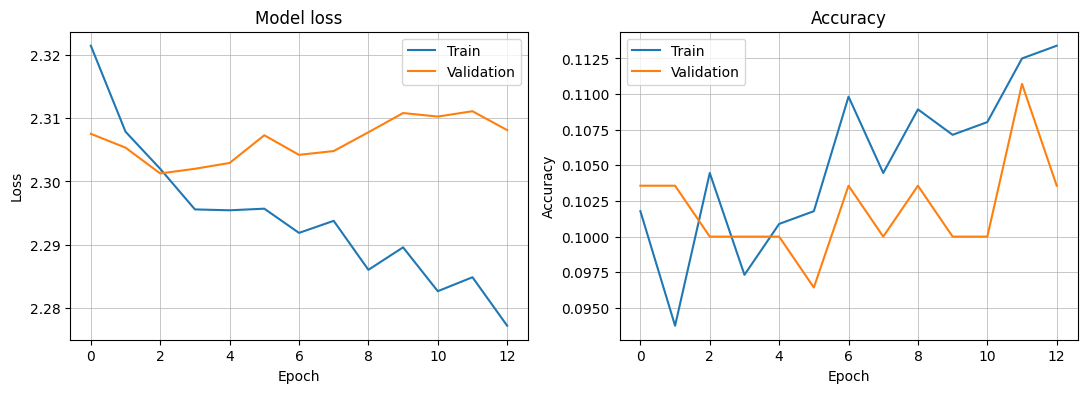

In [32]:
model_utils.plot_history(history)

## V2

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, SimpleRNN, LSTM, Dense, Dropout, Masking, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

# Define model
model = Sequential()

# Input layer with masking
model.add(Input(shape=(n_frames, n_landmarks * 3)))
model.add(Masking(mask_value=MASK_VALUE))

# Batch normalization
model.add(BatchNormalization())



# Recurrent layers
model.add(Bidirectional(SimpleRNN(units=256, return_sequences=True)))
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model.add(GRU(units=256, return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax'))



# Print model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)             │ (None, 100, 225)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 225)       │           900 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 512)       │       246,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,448,142 (9.34 MB)

 Trainable params: 2,447,692 (9.34 MB)

 Non-trainable params: 450 (1.76 KB)

In [26]:
# Optimizer with gradient clipping
optimizer = Adam(clipnorm=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Fitting

paths = model_utils.create_model_folder()
patience=10
epochs=100
verbose=1
batch_size=32
validation_data=(X_val, y_val)
shuffle=False

model, history = train_model(model, X_train, y_train,
                                 patience=patience,
                                 epochs=epochs,
                                 verbose=verbose,
                                 batch_size=batch_size,
                                 validation_data=validation_data,
                                 shuffle=shuffle,
                                 model_save_epoch_path=paths['iter']
                                 )


Training model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1666 - loss: 2.3771 - val_accuracy: 0.1429 - val_loss: 2.4291 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3325 - loss: 1.9536 - val_accuracy: 0.1786 - val_loss: 2.4510 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5611 - loss: 1.5074 - val_accuracy: 0.1786 - val_loss: 2.3394 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7062 - loss: 1.0415 - val_accuracy: 0.1964 - val_loss: 2.3413 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8062 - loss: 0.7019 - val_accuracy: 0.1071 - val_loss: 2.5647 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8354 - loss: 0.6054 - val_accuracy: 0.1429 - val_loss: 2.5910 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8578 - loss: 0.4611 - va

## Model 3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Concatenate

# Define input layer
input_layer = Input(shape=(n_frames, n_landmarks * 3))

# Branch 1: Convolutional layers
conv_branch = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
conv_branch = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv_branch)
conv_branch = BatchNormalization()(conv_branch)
conv_branch = Dropout(0.3)(conv_branch)

# Branch 2: Recurrent layers
rnn_branch = Bidirectional(SimpleRNN(units=256, return_sequences=True))(input_layer)
rnn_branch = Bidirectional(LSTM(units=256, return_sequences=True))(rnn_branch)
rnn_branch = GRU(units=256, return_sequences=True)(rnn_branch)
rnn_branch = Dense(128, activation='relu')(rnn_branch)
rnn_branch = Dropout(0.3)(rnn_branch)

# Merge branches
merged = Concatenate()([conv_branch, rnn_branch])

# Fully connected layers
output = Dense(128, activation='relu')(merged)
output = Dropout(0.5)(output)
output = Dense(num_classes, activation='softmax')(output)

# Define model
model = Model(inputs=input_layer, outputs=output)

# Print model summary
model.summary()
